# Segmentation from video file
This is a basic notebook for segmentation from a video file using the Tensorflow API. \
The aim is to apply a segmentation model to each frame of a video file and render the overlap of 
the image together with the segmentation mask

Below is an example of the segmentation that can be produced from a video with a dog.
The video can be found [here]().

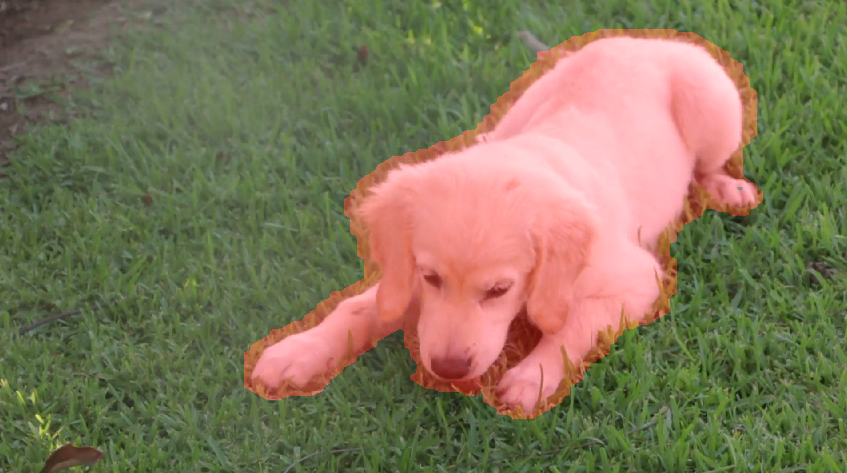

In [3]:
# importing libraries
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-02-28 11:14:59.209495: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 11:14:59.255961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 11:14:59.255996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 11:14:59.257328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 11:14:59.264829: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 11:14:59.265357: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Load the model
The model used for segmentation is a U-Net model that I coded. The model can be retrieved [here]().

In [4]:
model = tf.keras.models.load_model("model-unet")

### Data preparation
Prepare the data so the frames extracted from the video can be fed into the model

In [28]:
INPUT_SIZE = (128, 128) # model accepts 128*128*3 tensor images
OUTPUT_SIZE = (1080, 1920)

In [41]:
def normalize(input_image: np.ndarray | tf.Tensor) -> tf.Tensor:
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [7]:
def resize(image: np.ndarray | tf.Tensor) -> tf.Tensor:
  input_image = tf.image.resize(image, INPUT_SIZE)
  return input_image

In [8]:
def get_mask_from_frame(frame: np.ndarray) -> np.ndarray:
    frame_norm = normalize(frame)
    frame_resized = resize(frame)

    # Get frame in proper shape to be fed to model
    frame_expanded = tf.expand_dims(frame_resized, axis=0)
    pred = model.predict(frame_expanded)
    return pred[0]

### Apply the model on the video
Apply the model on each frame of the video to generate the segmentation mask and render \
the frame togheter with the segmentation mask.

In [ ]:
# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('dog_video.mp4')

# Check if camera opened successfully
if (cap.isOpened() == False):
    print("Error opening video file")

    # Read until video is completed
while (cap.isOpened()):

    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # Display the resulting frame

        mask = get_mask_from_frame(frame)

        # Resize mask to frame shape
        mask = tf.image.resize(mask,OUTPUT_SIZE).numpy()

        # Extract contour from mask
        object,_,contour = cv2.split(mask)
        object_contour_mask = object + contour
        object_contour_mask = np.round(object_contour_mask).astype(np.uint8)

        # Create final 3d mask
        x = np.zeros(shape=r.shape, dtype=np.uint8)
        seg_mask = cv2.merge([x,x,100*object_contour_mask])
      
        cv2.namedWindow("output", cv2.WINDOW_NORMAL)

        # merge video frame and seg_mask in same frame
        dst = cv2.addWeighted(frame,0.9,seg_mask,0.9,0)
        cv2.imshow('output', dst) 
        
        # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Break the loop
    else:
        break

# When everything done, release
# the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()